In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # "font.serif": ["Palatino"],
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 16,
    "font.size": 16,
    "axes.titlesize" : 16,
    # 'text.latex.preamble': r'\usepackage{amsfonts, amsmath,amssymb, mathrsfs}',
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14, 
    'figure.autolayout': True
    
}

import matplotlib.pyplot as plt 
import matplotlib
plt.rcParams.update(tex_fonts)

def generate_colormap_matrix(colormap_name, size):
    cmap = plt.get_cmap(colormap_name)
    norm = plt.Normalize(0, size - 1)

    colors = cmap(norm(range(size)))
    colors = np.reshape(colors, (size, 4))

    return colors

In [2]:
#### WESTERN EUROPE ####
df_list = []
df = pd.read_csv('Data FAO/FAOSTAT_AREA.csv')
df_list.append(df)
df = pd.read_csv('Data FAO/FAOSTAT_YIELD.csv')
df_list.append(df)
df = pd.read_csv('Data FAO/FAOSTAT_FERTILIZER.csv')
df_list.append(df)
df = pd.read_csv('Data FAO/FAOSTAT_PESTICIDE.csv')
df_list.append(df)
df_Price = pd.read_csv('Data FAO/commodity-price-index-cereal-crops-and-petroleum.csv')
df_Price = df_Price.rename(columns={"Wheat": "Value"})
condition = df_Price['Year'] >= 1961
df_Price = df_Price[condition]
df_list.append(df_Price)

In [3]:
ymax = 9  # Maximum achievable yield
Nr = 60  # Nutrient response parameter
p0 = 500  # Initial fixed operational cost
p1 = 1000  # Additional non operational cost
p_F = 0.8  # Price of fertilizer

num_steps = 100  # Number of simulation time steps
size = 100  # Number of farmers

omega_plus = 0.1
omega_minus = 0.1
competitiveness_param = 10  # Exponent in households' utility function
beta = 5  # Land redistribution parameter
theta = 0 #-np.inf  # Threshold wealth for farmer bankruptcy
delta = 0.1 # R&D investment fraction
demand_growth = 0.025  # Demand growth rate


In [4]:
def production(F_, M, land_per_farmer_):
    prod_ = land_per_farmer_ * ymax * (1 - np.exp(-1/Nr * (M * F_)))
    shape = np.concatenate((np.array(prod_.shape), [np.max(land_per_farmer_).astype(int)]), dtype=tuple)
    noise = np.random.normal(0, 0.05, shape) 
    weight = np.arange(np.max(land_per_farmer_))[np.newaxis, : ] <= land_per_farmer_[:,None] -1
    nan_vector = np.ones(weight.shape) 
    nan_vector[np.invert(weight)] = np.nan
    prod_ = np.nanmean(prod_[:, np.newaxis] * (1 + noise) * nan_vector, axis=-1)
    return prod_
    
def F_optimal(pM, ySold, kappa, M, S, L, delta):
    
    pM = pM - delta 
    b = pM * L * ymax/Nr - 2 * kappa * L * pM * S * ymax/Nr - 2 * kappa * L**2 * pM * ymax**2/Nr  + 2 * kappa * L * pM * ySold * ymax / Nr
    c = - L * p_F
    a = 2 * kappa * L**2 * pM * ymax**2 / Nr
    
    x1 = (-b + np.sqrt(b**2 - 4 * a * c))/(2*a)

    F_opt = - Nr/M * np.log(x1) * (1 + np.random.normal(0, 0.01, size = x1.shape)) 
    F_opt[F_opt < 0]  = 0
    Prod_opt = S + L * ymax * (1 - np.exp(- M*F_opt/Nr))
    Profit_opt = pM * Prod_opt - L * (F_opt + p0) - p1

    return F_opt, Profit_opt, Prod_opt
    

# Arrays to store values over the simulation
land_per_farmer = np.zeros((num_steps, size))
F = np.zeros((num_steps, size))
MP = np.zeros((num_steps, size))
inertia_rate = np.zeros((num_steps, size))
storage = np.zeros((num_steps, size))
expected_profit = np.zeros((num_steps, size))
expected_prod = np.zeros((num_steps, size))
prod = np.zeros((num_steps, size))
price = np.zeros((num_steps, size))
profit = np.zeros((num_steps, size))
revenues = np.zeros((num_steps, size))
costs = np.zeros((num_steps, size))
wealth = np.zeros((num_steps, size))
demand_per_farmer = np.zeros((num_steps, size))
fraction_sold = np.zeros((num_steps, size))
research_investment = np.zeros((num_steps, size))
quitting = np.zeros((num_steps, size))
active_farmer = np.zeros((num_steps, size), dtype=bool)
demand = np.zeros(num_steps)
market_price = np.zeros(num_steps)
delta_p_M = np.zeros(num_steps)


active_farmer[0] = True
land_per_farmer[0] = 1
F[0] = np.random.uniform(low = 30, high = 70, size = size)
MP[0] = np.random.uniform(low = 0.4, high=0.5, size=size)
inertia_rate[0] = np.random.uniform(low= 1, high = 2, size=size)
prod[0] = production(F[0], MP[0], land_per_farmer[0])
costs[0] = land_per_farmer[0] * (F[0] * p_F + p0) + p1
price[0] = costs[0]/prod[0]
wealth[0] = 10000
research_investment[0] = 0
storage[0] = 0


demand[0] = np.sum(prod[0])
exp =  prod[0] * np.exp(competitiveness_param *(price[0]-price[0].min())/price[0].max()) 
exp /= np.sum(exp)
fraction_sold[0] = 1/prod[0] * (prod[0] - exp * (np.sum(prod[0]) - demand[0])) if np.sum(prod[0]) - demand[0] > 0 else 1
market_price[0] = np.nanmax(np.where(fraction_sold[0] > 0.01, price[0], np.nan))
revenues[0] = market_price[0] * fraction_sold[0] * prod[0]
profit[0] = revenues[0] - costs[0]

quitting[0] = 100
expected_profit[0] = profit[0]
expected_prod[0] = prod[0]

delta_p_M[0] = 100

for t in range(1, num_steps):
    print(t)
    active_farmer[t] = quitting[t-1] > theta
    land_per_farmer[t] = land_per_farmer[t-1]

    # Land market in case of bankruptcy
    prod_share = np.zeros(size)
    if np.any(quitting[t-1] < theta):
        prob = active_farmer[t] * np.exp(beta * (wealth[t-1] * active_farmer[t-1] - wealth[t-1, active_farmer[t]].min()) / wealth[t-1, active_farmer[t]].max()) / np.sum( active_farmer[t] * np.exp(beta * (wealth[t-1] * active_farmer[t-1] - wealth[t-1, active_farmer[t]].min()) / wealth[t-1, active_farmer[t]].max()))
        auction_winner = np.random.choice(size, int(np.sum(land_per_farmer[t, quitting[t-1] * active_farmer[t-1] < theta])), p=prob, replace=True)
        indices, new_land = np.unique(auction_winner, return_counts=True)
        winners = np.zeros(size)
        winners[indices] = new_land
        land_per_farmer[t, winners > 0] += winners[winners > 0]
        land_per_farmer[t, quitting[t-1] * active_farmer[t-1] < theta] = 0  
        prod_share = winners * np.sum(fraction_sold[t-1] * prod[t-1] * (quitting[t-1] * active_farmer[t-1] < theta))/np.sum(winners)

    # Forcast and production phase
    F[t, active_farmer[t]], expected_profit[t, active_farmer[t]], expected_prod[t, active_farmer[t]] = F_optimal(market_price[t-1], fraction_sold[t-1, active_farmer[t]] * prod[t-1, active_farmer[t]] + prod_share[active_farmer[t]], inertia_rate[t-1, active_farmer[t]], MP[t-1, active_farmer[t]], storage[t-1, active_farmer[t]], land_per_farmer[t, active_farmer[t]], delta=0)
    prod[t, active_farmer[t]] = storage[t-1, active_farmer[t]] + production(F[t, active_farmer[t]], MP[t-1,active_farmer[t]], land_per_farmer[t,active_farmer[t]]) 
    costs[t, active_farmer[t]] = land_per_farmer[t, active_farmer[t]] * (F[t, active_farmer[t]] * p_F + p0) + p1
    price[t, active_farmer[t]] = costs[t, active_farmer[t]]/prod[t, active_farmer[t]] 

    # Demand allocation and market price determination
    demand[t] = demand[t-1] + demand[t-1] * 0.15 * (1 - demand[t-1]/(2.3 * demand[0])) 
    exp =  prod[t, active_farmer[t]] * np.exp(competitiveness_param *(price[t, active_farmer[t]]-price[t, active_farmer[t]].min())/price[t, active_farmer[t]].max()) 
    exp /= np.sum(exp)
    fraction_sold[t, active_farmer[t]] = 1/prod[t, active_farmer[t]] * (prod[t, active_farmer[t]] - exp * (np.sum(prod[t, active_farmer[t]]) - demand[t])) if (np.sum(prod[t, active_farmer[t]]) - demand[t]) > 0 else 1
    market_price[t] = np.nanmax(np.where(fraction_sold[t, active_farmer[t]] > 0.01, price[t, active_farmer[t]], np.nan))
    if np.any(fraction_sold[t, active_farmer[t]]<0):
        raise

    # Compute profits and update wealth
    storage[t, active_farmer[t]]  = (1 - fraction_sold[t, active_farmer[t]]) * prod[t, active_farmer[t]]
    revenues[t, active_farmer[t]] = market_price[t] * fraction_sold[t, active_farmer[t]] * prod[t, active_farmer[t]]
    profit[t, active_farmer[t]] =  revenues[t, active_farmer[t]] - costs[t, active_farmer[t]]
    wealth[t, active_farmer[t]] = wealth[t-1, active_farmer[t]] + profit[t, active_farmer[t]]
    inertia_rate[t, active_farmer[t]] = inertia_rate[t-1, active_farmer[t]] * (1 + np.where(fraction_sold[t, active_farmer[t]] < 1, omega_plus, -omega_minus) * np.random.rand(np.sum(active_farmer[t])))
    delta_p_M[t] = 0.6 * delta_p_M[t-1] + 0.4 * (market_price[t-1] - market_price[t])
    
    # Research and innovation investment
    research_investment[t, active_farmer[t]] = delta * profit[t, active_farmer[t]] # research_investment[t-1, active_farmer[t]] + 
    farms_innovating = np.random.rand(np.sum(active_farmer[t])) < 1 - np.exp(- 1/100 * research_investment[t, active_farmer[t]])
    advancement = 0.15 * np.random.rand(np.sum(active_farmer[t])) * farms_innovating
    MP[t, active_farmer[t]] = MP[t-1, active_farmer[t]] + advancement * MP[t-1, active_farmer[t]]  * (1 - MP[t-1, active_farmer[t]])
    wealth[t, active_farmer[t]] = wealth[t, active_farmer[t]] - delta * profit[t, active_farmer[t]]

    # Decide if quitting 
    profit_rate = 0.
    quitting[t,active_farmer[t]] =  profit_rate * quitting[t-1,active_farmer[t]] + (1 - profit_rate) * expected_profit[t, active_farmer[t]]
    quitting[t, np.invert(active_farmer[t])] = theta

1
2


RuntimeError: No active exception to reraise

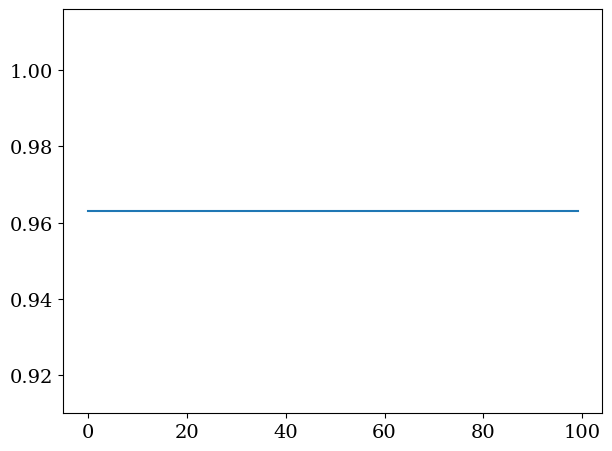

In [151]:
t = 2
competitiveness_param = 0
exp =  prod[t, active_farmer[t]] * np.exp(competitiveness_param *(price[t, active_farmer[t]]-price[t, active_farmer[t]].min())/price[t, active_farmer[t]].max()) 
exp /= np.sum(exp)
f = 1/prod[t, active_farmer[t]] * (prod[t, active_farmer[t]] - exp * (np.sum(prod[t, active_farmer[t]]) - demand[t])) 

plt.plot(f)

In [52]:
kappa = 10
t = 2
Delta = np.sum(prod[t, active_farmer[t]]) - demand[t]
pM = 1/kappa * np.log(1/demand[t] -1/np.sum(prod[t, active_farmer[t]])) * np.sum(prod[t, active_farmer[t]] * np.exp(kappa * price[t,active_farmer[t]]))
print(pM)

print(np.sum(1/(1 + np.exp(-kappa*(price[t, active_farmer[t]]-pM))) * prod[t, active_farmer[t]]))
print(demand[t])

-inf
344.8102086288273
337.31975526877164


In [14]:
exp =np.exp(competitiveness_param *(price[t, active_farmer[t]]-price[t, active_farmer[t]].min())/price[t, active_farmer[t]].max()) 
exp /= np.sum(exp)
print(exp)

[2.11130350e-03 1.04094716e-03 4.51003614e-03 9.66231867e-04
 5.36222994e-03 1.03734231e-03 9.47824557e-04 4.09314295e-02
 8.05036932e-04 2.19807978e-03 9.98684236e-04 2.98597360e-03
 5.94751500e-03 1.28047753e-03 1.26301484e-03 1.16546977e-03
 2.13467460e-03 3.87520688e-04 2.66334725e-03 9.48938484e-04
 2.04998516e-03 1.06193123e-03 2.76620582e-02 3.15524658e-03
 2.46577481e-03 2.45121322e-03 1.71296039e-03 1.85962475e-03
 5.17807164e-03 6.75138546e-04 2.17360700e-03 6.06569810e-04
 6.20667794e-04 5.54147865e-03 6.08521254e-04 1.20309123e-03
 7.37576276e-04 6.76282393e-01 1.13873377e-03 1.26500662e-03
 7.98351555e-04 7.15255237e-04 9.98158432e-04 6.07469262e-04
 7.43323997e-04 5.87956891e-04 3.82008524e-03 5.02391890e-03
 4.36771430e-04 1.27665398e-03 1.30842500e-03 1.46339052e-03
 8.10157064e-04 1.17506710e-03 1.16364165e-03 8.53710194e-02
 5.03650677e-03 9.84232645e-04 1.37771098e-03 1.04609257e-03
 5.14366200e-04 9.45056341e-04 9.07129973e-04 1.50201607e-03
 9.70325711e-04 1.142900

In [15]:
Delta/np.sum(active_farmer[t]) 

0.07490453360055653

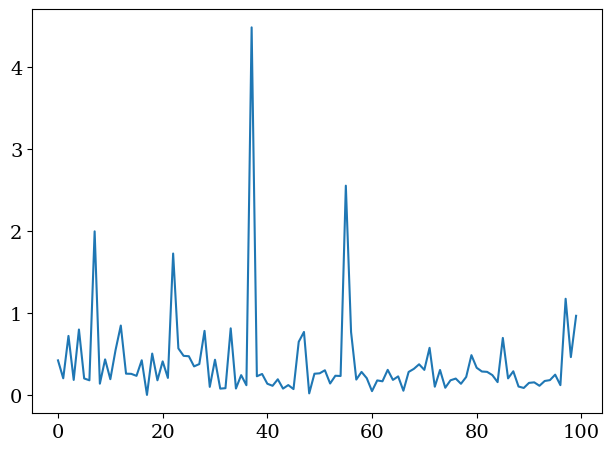

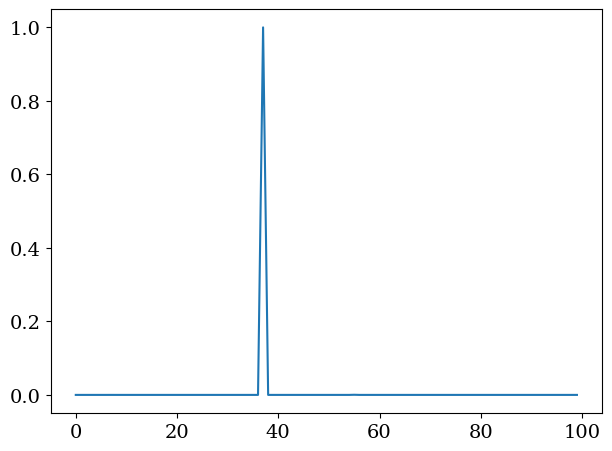

In [41]:
exp = prod[t, active_farmer[t]]  * np.exp(10*(price[t, active_farmer[t]] - price[t, active_farmer[t]].max())/price[t, active_farmer[t]].min())
exp /= np.sum(exp)
plt.plot(exp)


(array([6.546e+03, 2.217e+03, 7.750e+02, 2.980e+02, 1.000e+02, 3.900e+01,
        1.200e+01, 1.100e+01, 1.000e+00, 1.000e+00]),
 array([1.49748544e-06, 1.04832474e-02, 2.09649974e-02, 3.14467473e-02,
        4.19284972e-02, 5.24102472e-02, 6.28919971e-02, 7.33737471e-02,
        8.38554970e-02, 9.43372469e-02, 1.04818997e-01]),
 <BarContainer object of 10 artists>)

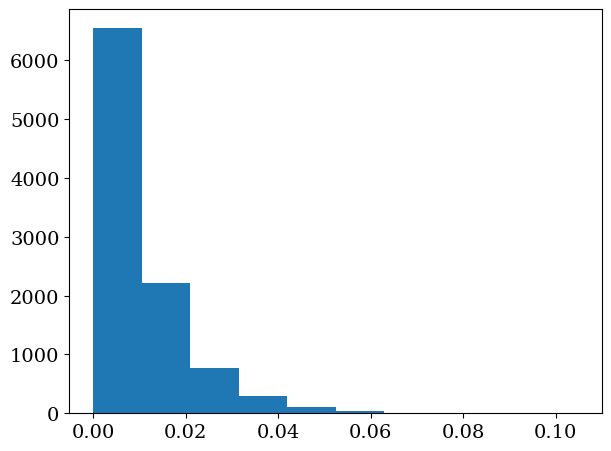

In [49]:
kappa = 100
rand = -np.log(1 - np.random.rand(10000)) / kappa

exp = prod

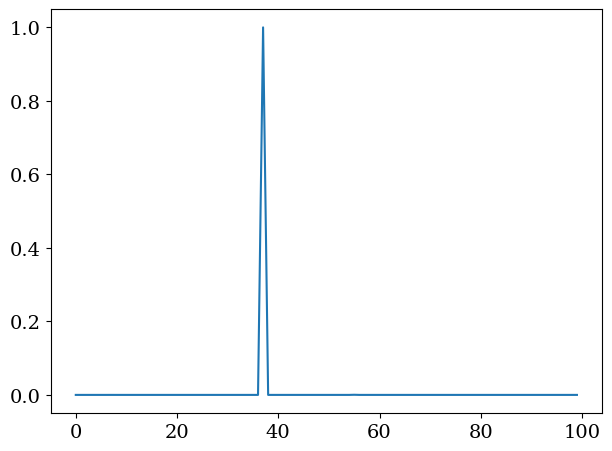

In [39]:
sexp1 = prod[t, active_farmer[t]] * exp
exp1 /= np.sum(exp1)

plt.plot(exp1)

7.490453360055658
7.490453360055653


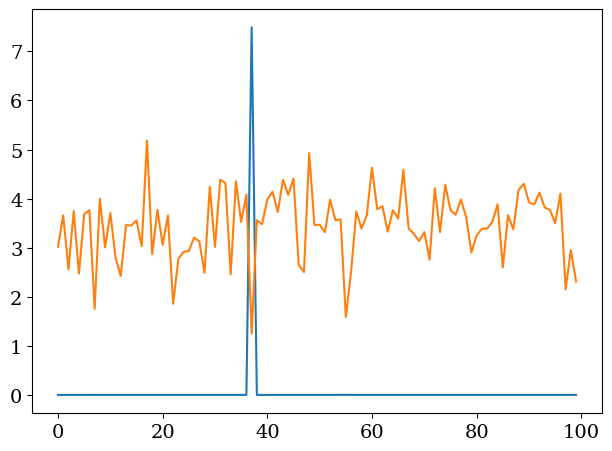

In [38]:
print(np.sum(Delta * exp1))
print(Delta)
plt.plot(Delta * exp1)
plt.plot(prod[t, active_farmer[t]])

12.237529785760955
-97487.65347086292


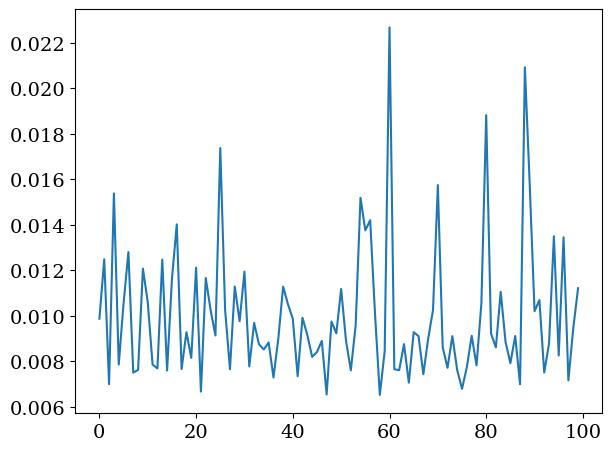

In [148]:
t = 2
competitiveness_param = 0
print(np.sum(prod[t, active_farmer[t]]) - demand[t])
exp = np.sum(prod[t, active_farmer[t]] - demand[t])/prod[t, active_farmer[t]] * np.exp(competitiveness_param *(price[t, active_farmer[t]]-price[t, active_farmer[t]].min())/price[t, active_farmer[t]].max()) 
exp /= np.sum(exp)

print(np.sum(prod[t, active_farmer[t]] - demand[t]) * np.sum(prod[t, active_farmer[t]] * exp))
plt.plot( exp )

# plt.plot(1/prod[t, active_farmer[t]] * (prod[t, active_farmer[t]] - exp * (np.sum(prod[t, active_farmer[t]]) - demand[t])))



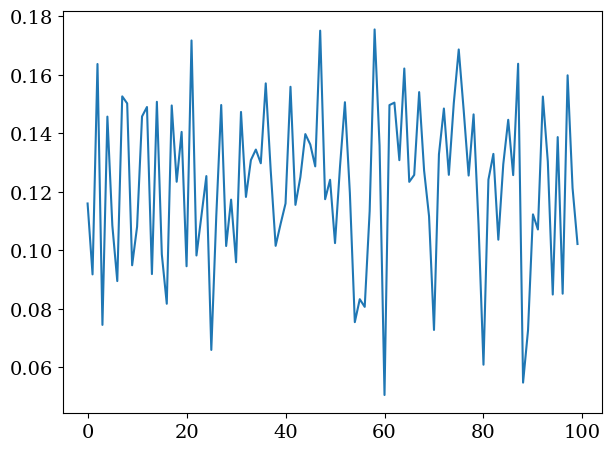

In [138]:
plt.plot((np.sum(prod[t, active_farmer[t]]) - demand[t]) * prod[t, active_farmer[t]] / np.sum(prod[t, active_farmer[t]]) )

In [134]:
 * np.sum(exp * prod[t, active_farmer[t]])

12.237529785760955

12.237529785760955


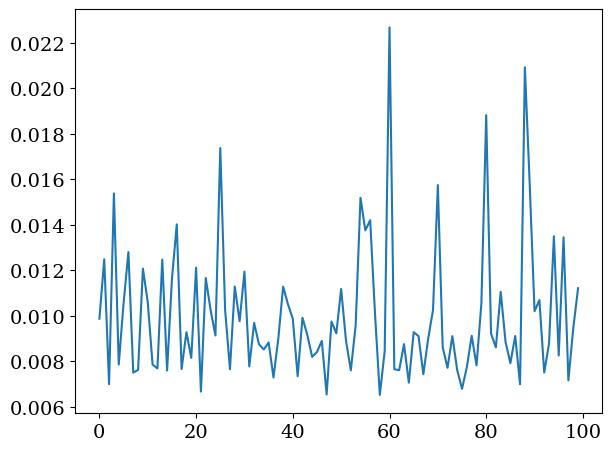

In [125]:
t = 2
competitiveness_param = 0
print(np.sum(prod[t, active_farmer[t]]) - demand[t])
exp =  np.exp(competitiveness_param *(price[t, active_farmer[t]]-price[t, active_farmer[t]].min())/price[t, active_farmer[t]].max()) 
exp /= np.sum(exp  * (np.sum(prod[t, active_farmer[t]]) - demand[t])/prod[t, active_farmer[t]])

plt.plot(exp * (np.sum(prod[t, active_farmer[t]]) - demand[t])/ prod[t, active_farmer[t]] )

# plt.plot()

In [124]:
np.sum(prod[t, active_farmer[t]] exp * (np.sum(prod[t, active_farmer[t]]) - demand[t]))

2.811040658666178

In [122]:
demand[t]

318.4207521395109

In [116]:
np.sum(exp * (np.sum(prod[t, active_farmer[t]]) - demand[t])/prod[t, active_farmer[t]])

1.0

In [ ]:

# if np.any(f < 0):
#     delta = np.zeros(np.sum(active_farmer[t]))
#     delta[f > 0] = np.sum(abs(prod[t, f < 0] * f[f < 0]))
#     delta[f < 0] = 1

#     new_exp = np.zeros(np.sum(active_farmer[t]))
#     new_exp[f > 0] =  prod[t, f > 0] * np.exp(competitiveness_param *(price[t, f > 0]-price[t, f > 0].min())/price[t, f > 0].max()) 
#     new_exp[f > 0] /= np.sum(new_exp[f > 0])
#     new_exp[f < 0] = prod[t, f<0]
#     exp[f<0] = 0

#     f = 1/prod[t, active_farmer[t]] * (prod[t, active_farmer[t]] - exp * (np.sum(prod[t, active_farmer[t]]) - demand[t]) - new_exp * delta)

# plt.plot(f)
# plt.plot(np.argwhere(f <0), -1, ls = '', marker = 'o')

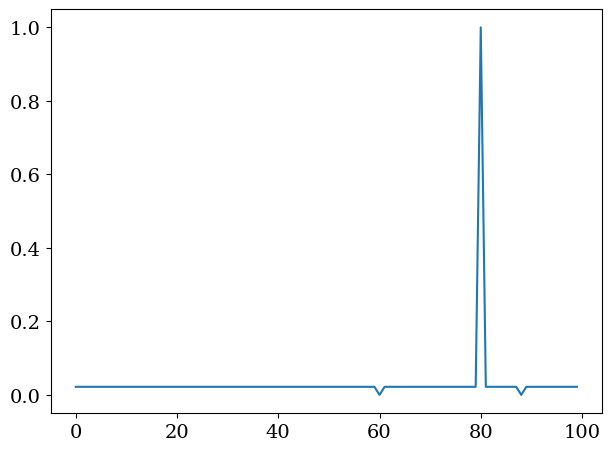

In [80]:
plt.plot(delta)

In [69]:
fraction_sold[2]

array([ 0.98828497,  0.96387022,  0.99666945,  0.8731367 ,  0.99515167,
        0.98403324,  0.95924542,  0.99587282,  0.99554762,  0.96979337,
        0.98410494,  0.99513871,  0.99546641,  0.96346943,  0.99575461,
        0.9744575 ,  0.92834486,  0.99554186,  0.99096467,  0.99436134,
        0.96889893,  0.99709895,  0.97416711,  0.98614134,  0.991461  ,
        0.69147204,  0.98621217,  0.99550287,  0.97822901,  0.98877905,
        0.97136482,  0.99521442,  0.98915615,  0.99281711,  0.99337423,
        0.99248259,  0.99621534,  0.99181132,  0.97802592,  0.98438284,
        0.98841373,  0.99607356,  0.98804868,  0.99152082,  0.9943346 ,
        0.99379903,  0.99227832,  0.99726861,  0.98876868,  0.99117865,
        0.97942319,  0.99235158,  0.995683  ,  0.98980047,  0.88268453,
        0.93698682,  0.92333218,  0.98703017,  0.99731966,  0.99353339,
       -1.98532381,  0.9955742 ,  0.99565054,  0.99273397,  0.99654752,
        0.99092526,  0.99174316,  0.9959381 ,  0.99199809,  0.98

In [67]:
exp[f<0] * (np.sum(prod[t, active_farmer[t]]) - demand[t]) - prod[t, f<0]

array([ 2.70860035, -0.72515451,  0.5600462 ])

In [63]:
fraction_sold[t]

array([ 0.98828497,  0.96387022,  0.99666945,  0.8731367 ,  0.99515167,
        0.98403324,  0.95924542,  0.99587282,  0.99554762,  0.96979337,
        0.98410494,  0.99513871,  0.99546641,  0.96346943,  0.99575461,
        0.9744575 ,  0.92834486,  0.99554186,  0.99096467,  0.99436134,
        0.96889893,  0.99709895,  0.97416711,  0.98614134,  0.991461  ,
        0.69147204,  0.98621217,  0.99550287,  0.97822901,  0.98877905,
        0.97136482,  0.99521442,  0.98915615,  0.99281711,  0.99337423,
        0.99248259,  0.99621534,  0.99181132,  0.97802592,  0.98438284,
        0.98841373,  0.99607356,  0.98804868,  0.99152082,  0.9943346 ,
        0.99379903,  0.99227832,  0.99726861,  0.98876868,  0.99117865,
        0.97942319,  0.99235158,  0.995683  ,  0.98980047,  0.88268453,
        0.93698682,  0.92333218,  0.98703017,  0.99731966,  0.99353339,
       -1.98532381,  0.9955742 ,  0.99565054,  0.99273397,  0.99654752,
        0.99092526,  0.99174316,  0.9959381 ,  0.99199809,  0.98

In [17]:
demand[t]

318.4207521395109

In [16]:
np.sum(fraction_sold[t, active_farmer[t]] * prod[t])

318.4207521395109

In [21]:
prod[2, 60] - exp[60] * (np.sum(prod[t, active_farmer[t]]) - demand[t])

-2.7086003531023324

In [20]:
exp[60]

0.33282141503751583

In [18]:
np.argwhere(fraction_sold[t, active_farmer[t]]  <0)

array([[60],
       [88]], dtype=int64)

Text(0.5, 1.0, 'Land per Farmer')

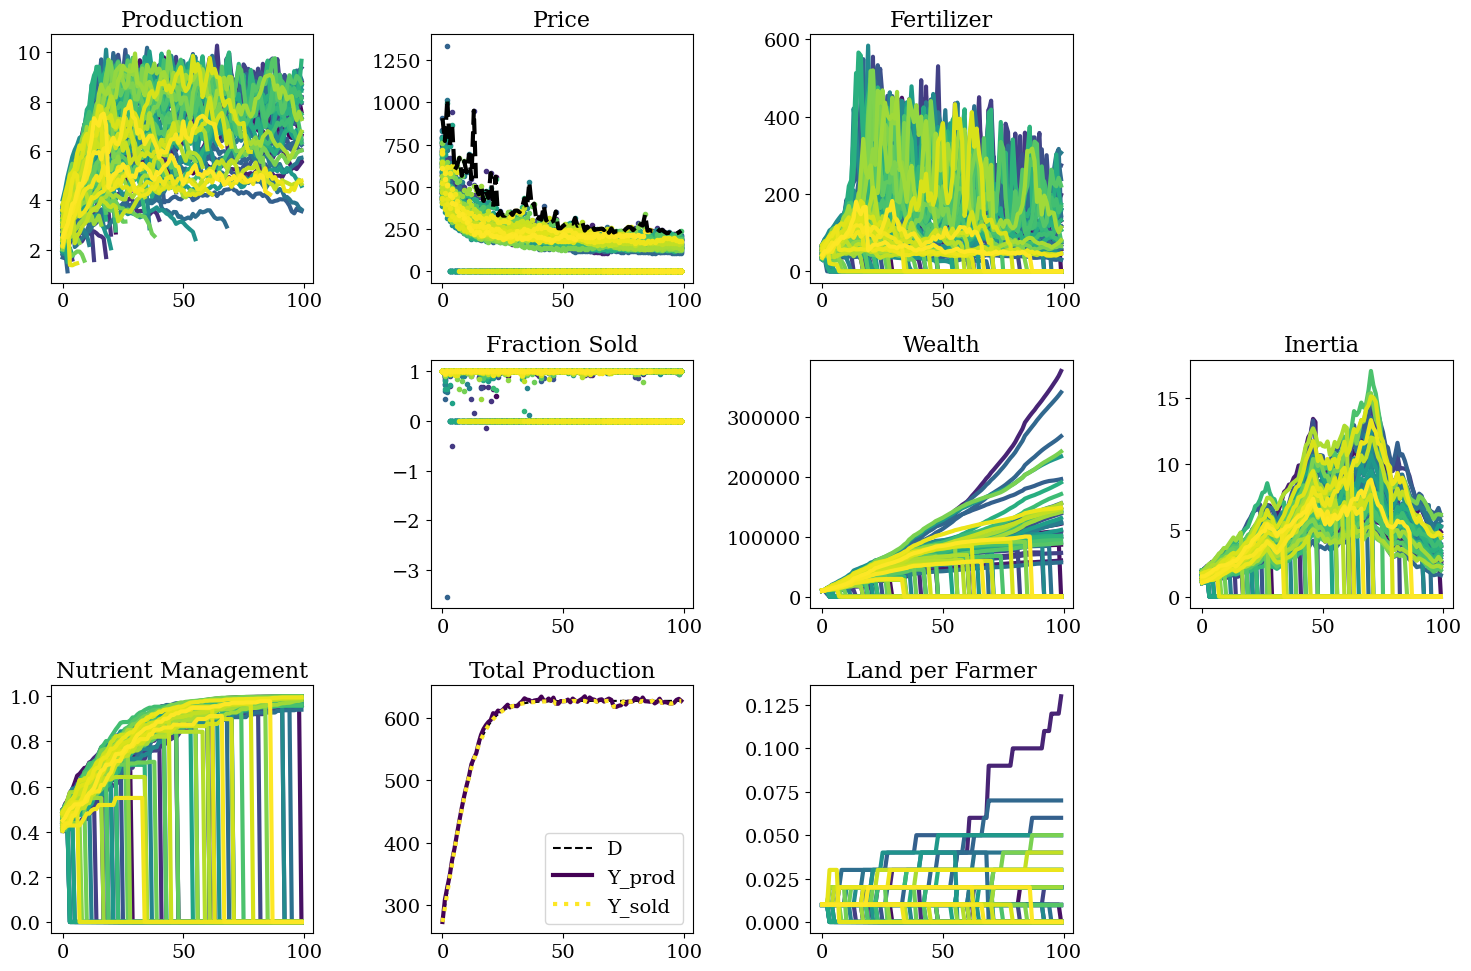

In [10]:

fig = plt.figure(figsize=(15,10))
gs = GridSpec(nrows=3, ncols=4)

c_matrix = generate_colormap_matrix('viridis', size)

# Plotting demand and production
ax = fig.add_subplot(gs[0, 0])
for i in range(size):
    ax.plot(range(num_steps), prod[:, i]/land_per_farmer[:,i], linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Production')

# Plotting price and market price
ax = fig.add_subplot(gs[0, 1])
for i in range(size):
    ax.plot(range(num_steps), price[:, i], linestyle='', marker = '.', c=c_matrix[i], lw = 3)
ax.plot(range(num_steps), market_price, linestyle='--', color='k', lw = 3)
ax.set_title('Price')

# Plotting fertilizer
ax = fig.add_subplot(gs[0, 2])
for i in range(size):
    ax.plot(range(num_steps), F[:, i], label='F', linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Fertilizer')

# ax = fig.add_subplot(gs[1, 0])
# for i in range(size):
#     ax.plot(range(num_steps), demand_per_farmer[:, i], label='F', linestyle='-', c=c_matrix[i], lw = 3)
# ax.set_title('Demand per farmer')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 2])
for i in range(size):
    ax.plot(range(num_steps), wealth[:, i], linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Wealth')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 3])
for i in range(size):
    ax.plot(range(num_steps), inertia_rate[:, i], linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Inertia')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 1])
for i in range(size):
    ax.plot(range(num_steps), fraction_sold[:, i], linestyle='', marker = '.', c=c_matrix[i], lw = 3)
ax.set_title('Fraction Sold')

ax = fig.add_subplot(gs[2, 0])
for i in range(size):
    ax.plot(range(num_steps), MP[:, i], linestyle='-', marker = '', c=c_matrix[i], lw = 3)
ax.set_title('Nutrient Management')

ax = fig.add_subplot(gs[2, 1])
ax.plot(range(num_steps), demand, linestyle='--', color='k', label ='D')
ax.plot(range(num_steps), np.sum(prod, axis=1), linestyle='-', c=c_matrix[0], lw = 3, label='Y_prod')
ax.plot(range(num_steps), np.sum(fraction_sold * prod, axis=1), linestyle=':', c=c_matrix[-1], lw = 3, label='Y_sold')
ax.set_title('Total Production')
ax.legend()


ax = fig.add_subplot(gs[2, 2])
for i in range(size):
    ax.plot(range(num_steps), land_per_farmer[:, i]/size, linestyle='-', marker = '', c=c_matrix[i], lw = 3)
ax.set_title('Land per Farmer')

In [1]:
plt.plot(np.mean(profit - expected_profit, axis=1)/np.mean(profit, axis=1));

NameError: name 'plt' is not defined

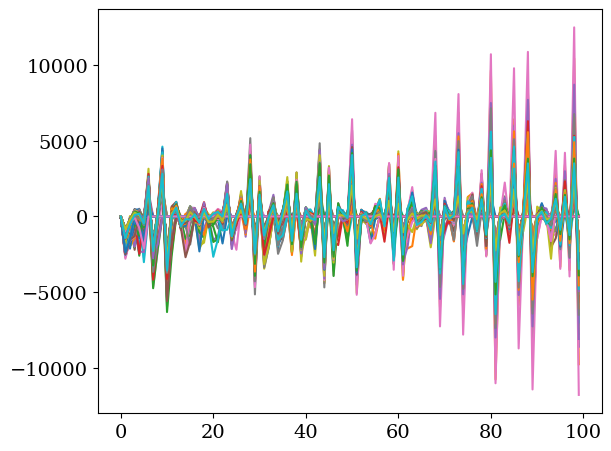

In [28]:
plt.plot(profit- expected_profit);

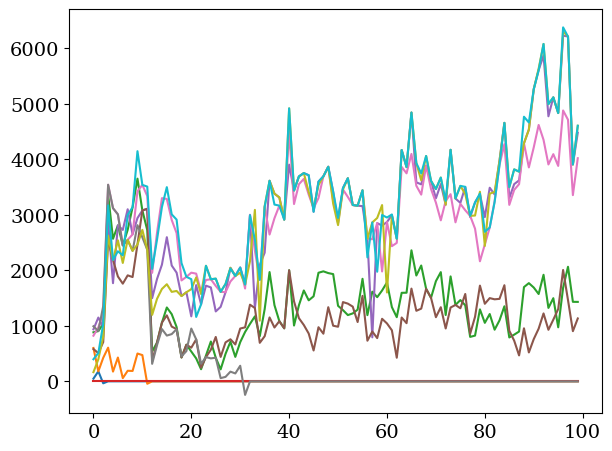

In [28]:
plt.plot(expected_profit);

Text(0.5, 1.0, 'Land per Farmer')

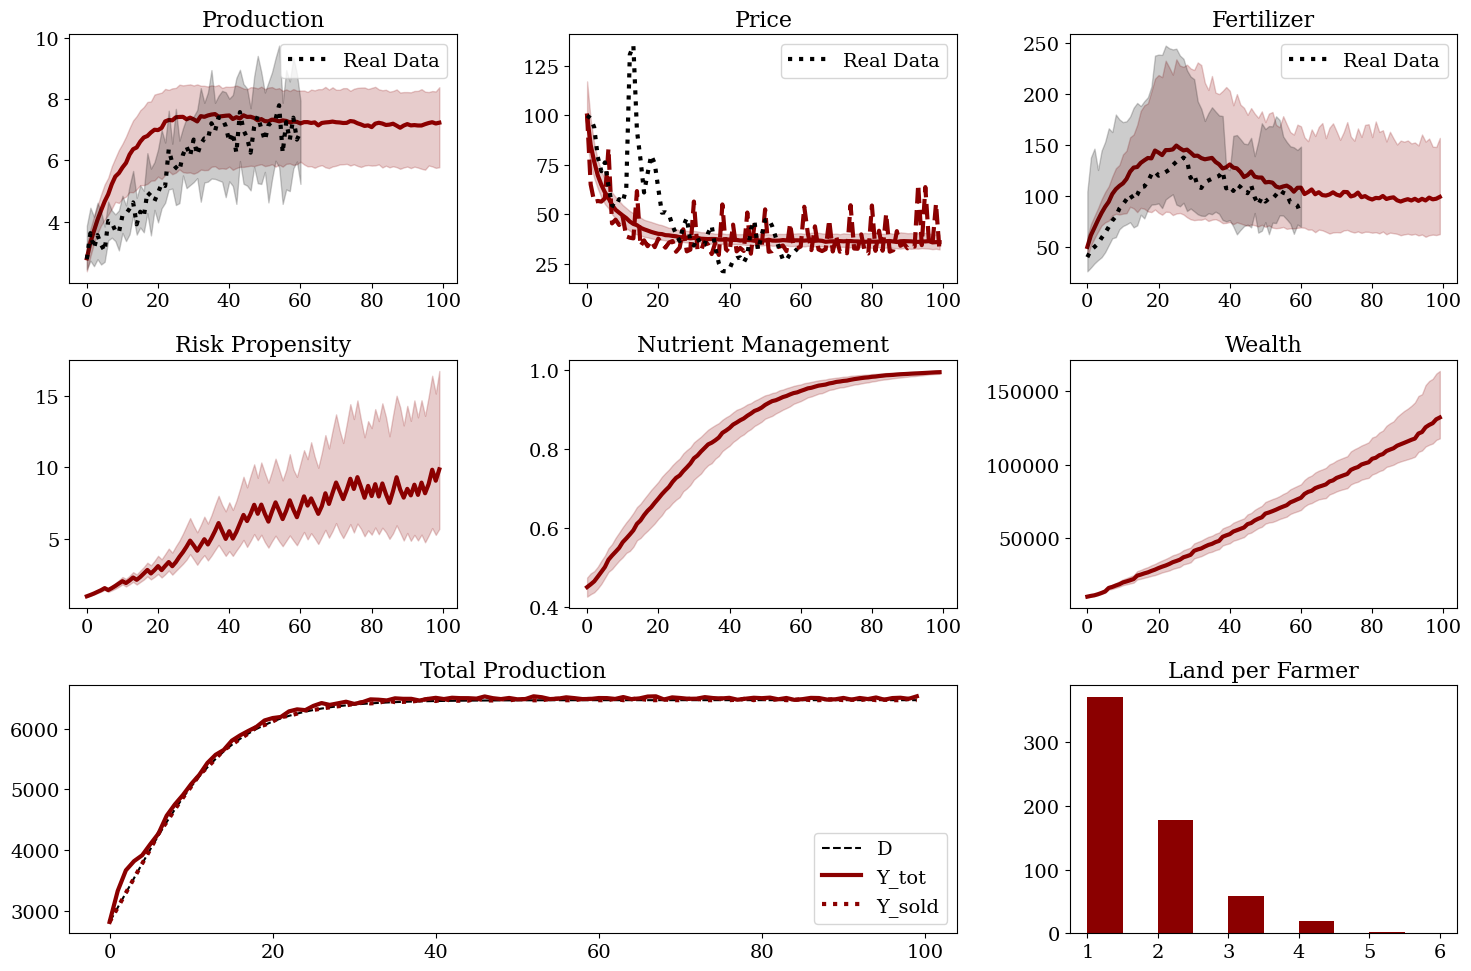

In [33]:
fig = plt.figure(figsize=(15,10))
gs = GridSpec(nrows=3, ncols=3)

c_matrix = generate_colormap_matrix('viridis', size)
color = 'darkred'

min_per = 25
max_per = 75

# Plotting demand and production
ax = fig.add_subplot(gs[0, 0])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), prod[active_farmer[:,i], i]/land_per_farmer[active_farmer[:,i], i], linestyle='-', c=color, lw = 0.5)
per_50 = np.nanpercentile(np.where(active_farmer == True, prod/land_per_farmer, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, prod/land_per_farmer, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, prod/land_per_farmer, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50, c=color, ls='-', lw = 3, zorder = 0.5)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 0.5)
df = df_list[1]
df = df[['Year', 'Area', 'Value']]
df_pivot = df.pivot('Year', 'Area', values='Value')
per_50 = np.nanpercentile(df_pivot, 50, axis=1)/10000
per_5 = np.nanpercentile(df_pivot, 5, axis=1)/10000
per_95 = np.nanpercentile(df_pivot, 95, axis=1)/10000
year = df_pivot.index.to_numpy()
ax.plot(range(per_50.size), per_50, c='k', ls=':', label='Real Data', lw = 3)
ax.fill_between(range(per_50.size), per_5, per_95, color='k', alpha=0.2)
ax.legend()
ax.set_title('Production')


# Plotting price and market price
ax = fig.add_subplot(gs[0, 1])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), price[active_farmer[:,i], i], linestyle='', marker = '.', c=c_matrix[i], lw = 3)
per_50 = np.nanpercentile(np.where(active_farmer == True, price, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, price, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, price, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50/per_50[0]*100, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5/per_50[0]*100, per_95/per_50[0]*100, color=color, alpha=0.2, zorder = 1)
ax.plot(range(num_steps), market_price/market_price[0]*100, linestyle='--', color='darkred', lw = 3, zorder = 2)
df = df_list[-1]
ax.plot(range(df['Year'].size), df['Value']/df['Value'].iloc[0]*100, c = 'k', ls = ':', lw = 3, label='Real Data')
ax.legend()
ax.set_title('Price')


# Plotting fertilizer
ax = fig.add_subplot(gs[0, 2])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), F[active_farmer[:,i], i], label='F', linestyle='-', c=color, lw = 0.5,zorder = 0)
per_50 = np.nanpercentile(np.where(active_farmer == True, F, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, F, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, F, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
df = df_list[2]
df = df[['Year', 'Area', 'Value']]
df_pivot = df.pivot('Year', 'Area', values='Value')
per_50 = np.nanpercentile(df_pivot, 50, axis=1)
per_5 = np.nanpercentile(df_pivot, 5, axis=1)
per_95 = np.nanpercentile(df_pivot, 95, axis=1)
year = df_pivot.index.to_numpy()
ax.plot(range(per_50.size), per_50, c='k', ls=':', label='Real Data', lw = 3, zorder = 2)
ax.fill_between(range(per_50.size), per_5, per_95, color='k', alpha=0.2, zorder = 2)
ax.legend()
ax.set_title('Fertilizer')

ax = fig.add_subplot(gs[1, 0])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), Soil_health[active_farmer[:,i], i], label='F', linestyle='-', c=c_matrix[i], lw = 3)
per_50 = np.nanpercentile(np.where(active_farmer == True, inertia_rate, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, inertia_rate, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, inertia_rate, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.set_title('Risk Propensity')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 2])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), wealth[active_farmer[:,i], i], linestyle='-', c=c_matrix[i], lw = 3)
per_50 = np.nanpercentile(np.where(active_farmer == True, wealth, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, wealth, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, wealth, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.set_title('Wealth')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 1])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), MP[active_farmer[:,i], i], linestyle='-', marker = '', c=c_matrix[i], lw = 3)
per_50 = np.nanpercentile(np.where(active_farmer == True, MP, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, MP, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, MP, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.set_title('Nutrient Management')

ax = fig.add_subplot(gs[2, :2])
ax.plot(range(num_steps), demand, linestyle='--', color='k', label ='D')
ax.plot(range(num_steps), np.sum(prod, axis=1), linestyle='-', c=color, lw = 3, label = 'Y_tot')
ax.plot(range(num_steps), np.sum(fraction_sold * prod, axis=1), linestyle=':', c=color, lw = 3, label='Y_sold')
ax.set_title('Total Production')
ax.legend()

ax = fig.add_subplot(gs[2, 2])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), land_per_farmer[active_farmer[:,i], i]/size, linestyle='-', color=c_matrix[i], lw = 3)
# ax.plot(range(num_steps), np.sum(farmers_entering, axis=1)/size, linestyle='-', color=c_matrix[-1], lw = 3)
# per_50 = np.nanpercentile(np.where(active_farmer == True, land_per_farmer/size, np.nan), 50, axis=1)
# per_5 = np.nanpercentile(np.where(active_farmer == True, land_per_farmer/size, np.nan), min_per, axis=1)
# per_95 = np.nanpercentile(np.where(active_farmer == True, land_per_farmer/size, np.nan), max_per, axis=1)
# ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
# ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.hist(land_per_farmer[-1, active_farmer[-1]], facecolor ='darkred')
ax.set_title('Land per Farmer')

Text(0.5, 1.0, 'Fertilizer')

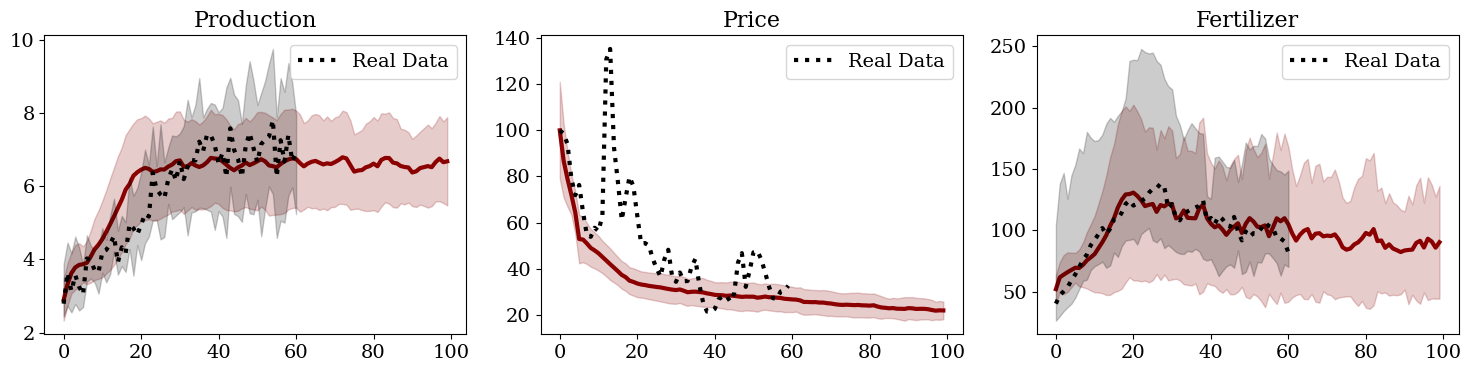

In [78]:
fig = plt.figure(figsize=(15,4))
gs = GridSpec(nrows=1, ncols=3)

c_matrix = generate_colormap_matrix('viridis', size)
color = 'darkred'

min_per = 5
max_per = 95

# Plotting demand and production
ax = fig.add_subplot(gs[0, 0])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), prod[active_farmer[:,i], i]/land_per_farmer[active_farmer[:,i], i], linestyle='-', c=color, lw = 0.5)
weighted_avg = np.average(np.where(active_farmer == True, prod/land_per_farmer, 0), weights=np.where(active_farmer == True, prod, 0), axis=1)
weighted_std  = np.sqrt(np.average((np.where(active_farmer == True, prod/land_per_farmer, 0) - weighted_avg[:, np.newaxis])**2, weights=np.where(active_farmer == True, prod/np.sum(prod), 0), axis=1))
ax.plot(range(weighted_avg.size), weighted_avg, c=color, ls='-', lw = 3, zorder = 0.5)
ax.fill_between(range(weighted_avg.size), weighted_avg - weighted_std, weighted_avg + weighted_std, color=color, alpha=0.2, zorder = 0.5)
df = df_list[1]
df = df[['Year', 'Area', 'Value']]
df_pivot = df.pivot('Year', 'Area', values='Value')
per_50 = np.nanpercentile(df_pivot, 50, axis=1)/10000
per_5 = np.nanpercentile(df_pivot, 5, axis=1)/10000
per_95 = np.nanpercentile(df_pivot, 95, axis=1)/10000
year = df_pivot.index.to_numpy()
ax.plot(range(per_50.size), per_50, c='k', ls=':', label='Real Data', lw = 3)
ax.fill_between(range(per_50.size), per_5, per_95, color='k', alpha=0.2)
ax.legend()
ax.set_title('Production')

# Plotting price and market price
ax = fig.add_subplot(gs[0, 1])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), price[active_farmer[:,i], i], linestyle='', marker = '.', c=c_matrix[i], lw = 3)
weighted_avg = np.average(np.where(active_farmer == True, price, 0), weights=np.where(active_farmer == True, prod, 0), axis=1)
weighted_std  = np.sqrt(np.average((np.where(active_farmer == True, price, 0) - weighted_avg[:, np.newaxis])**2, weights=np.where(active_farmer == True, prod/np.sum(prod), 0), axis=1))
ax.plot(range(weighted_avg.size), weighted_avg/weighted_avg[0]*100, c=color, ls='-', lw = 3, zorder = 0.5)
ax.fill_between(range(weighted_avg.size), (weighted_avg - weighted_std)/weighted_avg[0]*100, (weighted_avg + weighted_std)/weighted_avg[0]*100, color=color, alpha=0.2, zorder = 0.5)
# ax.plot(range(num_steps), market_price, linestyle='--', color='k', lw = 3, zorder = 2)
df = df_list[-1]
ax.plot(range(df['Year'].size), df['Value']/df['Value'].iloc[0]*100, c = 'k', ls = ':', lw = 3, label='Real Data')
ax.legend()
ax.set_title('Price')

# Plotting fertilizer
ax = fig.add_subplot(gs[0, 2])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), F[active_farmer[:,i], i], label='F', linestyle='-', c=color, lw = 0.5,zorder = 0)
weighted_avg = np.average(np.where(active_farmer == True, F, 0), weights=np.where(active_farmer == True, prod, 0), axis=1)
weighted_std  = np.sqrt(np.average((np.where(active_farmer == True, F, 0) - weighted_avg[:, np.newaxis])**2, weights=np.where(active_farmer == True, prod/np.sum(prod), 0), axis=1))
ax.plot(range(weighted_avg.size), weighted_avg, c=color, ls='-', lw = 3, zorder = 0.5)
ax.fill_between(range(weighted_avg.size), weighted_avg - weighted_std, weighted_avg + weighted_std, color=color, alpha=0.2, zorder = 0.5)
df = df_list[2]
df = df[['Year', 'Area', 'Value']]
df_pivot = df.pivot('Year', 'Area', values='Value')
per_50 = np.nanpercentile(df_pivot, 50, axis=1)
per_5 = np.nanpercentile(df_pivot, 5, axis=1)
per_95 = np.nanpercentile(df_pivot, 95, axis=1)
year = df_pivot.index.to_numpy()
ax.plot(range(per_50.size), per_50, c='k', ls=':', label='Real Data', lw = 3, zorder = 2)
ax.fill_between(range(per_50.size), per_5, per_95, color='k', alpha=0.2, zorder = 2)
ax.legend()
ax.set_title('Fertilizer')
